In [ ]:
# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

# Install dependencies
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17067, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 17067 (delta 24), reused 28 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17067/17067), 15.68 MiB | 16.34 MiB/s, done.
Resolving deltas: 100% (11719/11719), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 53.9 MB/s eta 0:00:00


In [ ]:
import os
import json

def convert_coco_to_yolo(coco_json_path, images_dir, output_dir):
    # Load COCO JSON annotations
    with open(coco_json_path) as f:
        coco_data = json.load(f)

    # Create directory for labels
    labels_dir = os.path.join(output_dir, "labels")
    os.makedirs(labels_dir, exist_ok=True)

    # Create a mapping for categories
    category_mapping = {cat['id']: cat['name'] for cat in coco_data['categories']}
    print("Category Mapping:", category_mapping)

    # Process each image
    for img in coco_data['images']:
        img_id = img['id']
        img_file_name = img['file_name']
        img_path = os.path.join(images_dir, img_file_name)

        # Ensure the image file exists
        if not os.path.exists(img_path):
            print(f"Image file not found: {img_path}")
            continue

        annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == img_id]

        # Handle missing annotations by creating an empty label file
        label_file = os.path.join(labels_dir, img_file_name.replace('.jpg', '.txt').replace('.png', '.txt'))
        if not annotations:
            with open(label_file, 'w') as f:
                f.write("")  # Write an empty file
            print(f"No annotations for {img_file_name}, created empty label file.")
            continue

        # Prepare YOLO annotations
        yolo_annotations = []
        for ann in annotations:
            category_id = ann['category_id']
            bbox = ann['bbox']  # [x_min, y_min, width, height]
            x_min, y_min, width, height = bbox
            x_center = x_min + width / 2
            y_center = y_min + height / 2

            # Normalize coordinates
            x_center /= img['width']
            y_center /= img['height']
            width /= img['width']
            height /= img['height']

            # YOLO format: <class_id> <x_center> <y_center> <width> <height>
            yolo_annotations.append(f"{category_id - 1} {x_center} {y_center} {width} {height}")

        # Write YOLO annotations to file
        with open(label_file, 'w') as f:
            f.write("\n".join(yolo_annotations))

        # Print the label file path for verification
        #print(f"Label file created: {label_file}")

    print("Conversion complete. Check:", output_dir)
    # Print the category IDs from annotations
    annotation_class_ids = [ann['category_id'] for ann in coco_data['annotations']]
    print("Annotation class IDs:", annotation_class_ids)
    print("Max class ID:", max(annotation_class_ids))


# Convert your dataset
convert_coco_to_yolo(
    coco_json_path="/content/drive/MyDrive/Object Recognition Dataset/instances_val2017.json/instances_val2017.json",  # Path to your COCO JSON
    images_dir="/content/drive/MyDrive/Object Recognition Dataset/val2017",               # Path to images
    output_dir="/content/yolo_dataset"                       # Output path for YOLO dataset
)

Category Mapping: {1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell 

In [ ]:
import shutil
import random
from glob import glob

images_dir = "/content/drive/MyDrive/Object Recognition Dataset/val2017"
labels_dir = "/content/yolo_dataset/labels"
output_dir = "/content/yolo_split"
train_ratio = 0.7  # For training set
val_ratio = 0.15   # For validation set
test_ratio = 0.15  # For testing set

# Create directories
os.makedirs(f"{output_dir}/images/train", exist_ok=True)
os.makedirs(f"{output_dir}/images/val", exist_ok=True)
os.makedirs(f"{output_dir}/images/test", exist_ok=True)
os.makedirs(f"{output_dir}/labels/train", exist_ok=True)
os.makedirs(f"{output_dir}/labels/val", exist_ok=True)
os.makedirs(f"{output_dir}/labels/test", exist_ok=True)

# Get image files and shuffle them
image_files = glob(f"{images_dir}/*.jpg")
random.shuffle(image_files)

# Limit the number of images to 500
image_files = image_files[:500]

# Split into train, validation, and test
train_size = int(len(image_files) * train_ratio)
val_size = int(len(image_files) * val_ratio)
test_size = len(image_files) - train_size - val_size  # Remaining images for testing

train_files = image_files[:train_size]
val_files = image_files[train_size:train_size + val_size]
test_files = image_files[train_size + val_size:]

# Helper function to create symlinks and print logs
def link_files(file_list, image_dest_dir, label_dest_dir):
    for file in file_list:
        file_name = os.path.basename(file)
        label_file = os.path.join(labels_dir, file_name.replace('.jpg', '.txt'))

        # Check if the symlink for the image already exists
        image_symlink_path = os.path.join(image_dest_dir, file_name)
        if not os.path.exists(image_symlink_path):
            os.symlink(file, image_symlink_path)
            print(f"Linked image: {file_name}")
        else:
            print(f"Image symlink already exists: {file_name}")

        # Check if the symlink for the label already exists
        label_symlink_path = os.path.join(label_dest_dir, os.path.basename(label_file))
        if os.path.exists(label_file):
            if not os.path.exists(label_symlink_path):
                os.symlink(label_file, label_symlink_path)
                print(f"Linked label: {os.path.basename(label_file)}")
            else:
                print(f"Label symlink already exists: {os.path.basename(label_file)}")
        else:
            print(f"Label file missing for {file_name}")

# Link training files
link_files(train_files, f"{output_dir}/images/train", f"{output_dir}/labels/train")

# Link validation files
link_files(val_files, f"{output_dir}/images/val", f"{output_dir}/labels/val")

# Link test files
link_files(test_files, f"{output_dir}/images/test", f"{output_dir}/labels/test")

# Verify contents of the directories after linking
print("Contents of labels directory:", os.listdir(labels_dir))
print("Contents of train labels directory:", os.listdir(f"{output_dir}/labels/train"))

Linked image: 000000024243.jpg
Linked label: 000000024243.txt
Linked image: 000000027620.jpg
Linked label: 000000027620.txt
Linked image: 000000482719.jpg
Linked label: 000000482719.txt
Linked image: 000000115885.jpg
Linked label: 000000115885.txt
Linked image: 000000404534.jpg
Linked label: 000000404534.txt
Linked image: 000000443498.jpg
Linked label: 000000443498.txt
Linked image: 000000540466.jpg
Linked label: 000000540466.txt
Linked image: 000000066635.jpg
Linked label: 000000066635.txt
Linked image: 000000085329.jpg
Linked label: 000000085329.txt
Linked image: 000000252507.jpg
Linked label: 000000252507.txt
Linked image: 000000108864.jpg
Linked label: 000000108864.txt
Linked image: 000000012667.jpg
Linked label: 000000012667.txt
Linked image: 000000134112.jpg
Linked label: 000000134112.txt
Linked image: 000000052413.jpg
Linked label: 000000052413.txt
Linked image: 000000012062.jpg
Linked label: 000000012062.txt
Linked image: 000000310622.jpg
Linked label: 000000310622.txt
Linked i

In [ ]:
yaml_content = """
train: /content/yolo_split/images/train
val: /content/yolo_split/images/val
test: /content/yolo_split/images/test

# number of classes
nc: 90

# class names
names:
  0: 'person'
  1: 'bicycle'
  2: 'car'
  3: 'motorcycle'
  4: 'airplane'
  5: 'bus'
  6: 'train'
  7: 'truck'
  8: 'boat'
  9: 'traffic light'
  10: 'fire hydrant'
  11: 'N/A'
  12: 'stop sign'
  13: 'parking meter'
  14: 'bench'
  15: 'bird'
  16: 'cat'
  17: 'dog'
  18: 'horse'
  19: 'sheep'
  20: 'cow'
  21: 'elephant'
  22: 'bear'
  23: 'zebra'
  24: 'giraffe'
  25: 'N/A'
  26: 'backpack'
  27: 'umbrella'
  28: 'N/A'
  29: 'N/A'
  30: 'N/A'
  31: 'handbag'
  32: 'tie'
  33: 'suitcase'
  34: 'frisbee'
  35: 'skis'
  36: 'snowboard'
  37: 'sports ball'
  38: 'kite'
  39: 'baseball bat'
  40: 'baseball glove'
  41: 'skateboard'
  42: 'surfboard'
  43: 'tennis racket'
  44: 'bottle'
  45: 'N/A'
  46: 'wine glass'
  47: 'cup'
  48: 'fork'
  49: 'knife'
  50: 'spoon'
  51: 'bowl'
  52: 'banana'
  53: 'apple'
  54: 'sandwich'
  55: 'orange'
  56: 'broccoli'
  57: 'carrot'
  58: 'hot dog'
  59: 'pizza'
  60: 'donut'
  61: 'cake'
  62: 'chair'
  63: 'couch'
  64: 'potted plant'
  65: 'bed'
  66: 'N/A'
  67: 'dining table'
  68: 'N/A'
  69: 'N/A'
  70: 'toilet'
  71: 'N/A'
  72: 'tv'
  73: 'laptop'
  74: 'mouse'
  75: 'remote'
  76: 'keyboard'
  77: 'cell phone'
  78: 'microwave'
  79: 'oven'
  80: 'toaster'
  81: 'sink'
  82: 'refrigerator'
  83: 'N/A'
  84: 'book'
  85: 'clock'
  86: 'vase'
  87: 'scissors'
  88: 'teddy bear'
  89: 'hair drier'
"""
with open("/content/yolo_split/train.yaml", "w") as f:
    f.write(yaml_content)


In [ ]:
import os

annotation_folder = '/content/yolo_split/labels/train'  # Adjust this path as needed
nc = 90  # Update this if your dataset has more classes

for filename in os.listdir(annotation_folder):
    if filename.endswith('.txt'):  # YOLO format annotations are usually .txt
        with open(os.path.join(annotation_folder, filename), 'r') as file:
            lines = file.readlines()
            for line in lines:
                class_id = int(line.split()[0])
                if class_id >= nc:
                    print(f"Invalid class {class_id} found in {filename}")


In [ ]:
!python train.py --img 640 --batch 16 --epochs 50 --data /content/yolo_split/train.yaml --weights yolov5s.pt


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-29 13:33:10.189151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 13:33:10.209786: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 13:33:10.215816: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visua

In [ ]:
!python detect.py --weights runs/train/exp6/weights/best.pt --img-size 640 --source /content/bear.jpg

detect: weights=['runs/train/exp6/weights/best.pt'], source=/content/bear.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7252855 parameters, 0 gradients, 16.5 GFLOPs
image 1/1 /content/bear.jpg: 384x640 2 persons, 31.1ms
Speed: 0.5ms pre-process, 31.1ms inference, 554.2ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp6


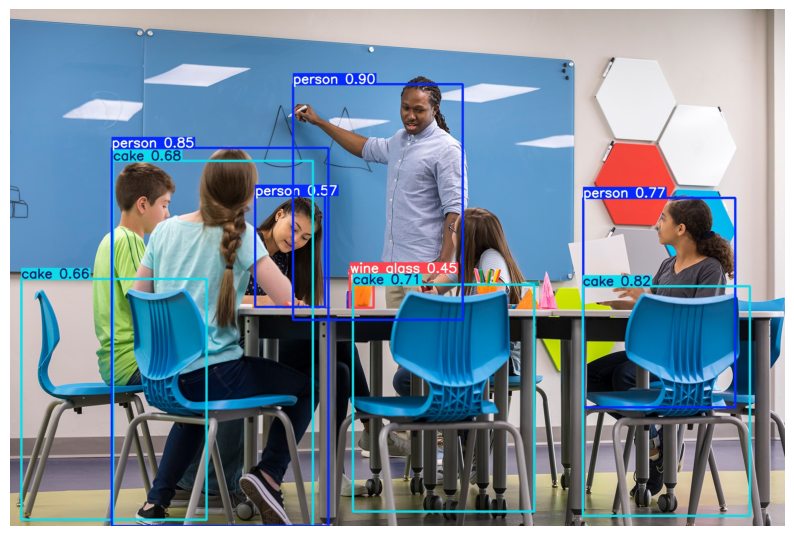

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Path to the output image from the detection
image_path = '/content/yolov5/runs/detect/exp4/class.jpg'

# Read the image using OpenCV
image = cv2.imread(image_path)
# Convert the image from BGR to RGB (matplotlib uses RGB)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')  # Hide axes for a cleaner look
plt.show()
